Todo

write function to exclude trials where they ran off the map
write function to exclude trials where pacman stays still
write function to flip through trials visually to inspect for any odd behavior

Next steps are still to basically keep going towards the goal of an image of trials stacked from shortest to longest with theta power as the color and time on the x axis.

Document along the way the functions that you will need to write to generalize this to other subjects.

Next debugging steps are to figure out whats up with other long trials (>6s) and longer ITIs as well.


In [1]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [2]:
%matplotlib qt5

In [3]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time[0], duration[0]        

In [ ]:
# highpass filter @ 1 and lowpass @ 200 #
filtered_data = mne_df.filter(l_freq=1, h_freq=150) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


In [4]:
# load/save filtered data

# filtered_notch_data.save('./BJH016_notched_filtered_ieeg.fif', overwrite = True)
filtered_notch_data = mne.io.Raw('./BJH016_notched_filtered_ieeg.fif')
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Opening raw data file ./BJH016_notched_filtered_ieeg.fif...
    Range : 0 ... 1963999 =      0.000 ...   982.000 secs
Ready.
Opening raw data file /home/brooke/pacman_ieeg/BJH016_notched_filtered_ieeg-1.fif...
    Range : 1964000 ... 3927999 =    982.000 ...  1963.999 secs
Ready.
Opening raw data file /home/brooke/pacman_ieeg/BJH016_notched_filtered_ieeg-2.fif...
    Range : 3928000 ... 5891999 =   1964.000 ...  2945.999 secs
Ready.
Opening raw data file /home/brooke/pacman_ieeg/BJH016_notched_filtered_ieeg-3.fif...
    Range : 5892000 ... 5901899 =   2946.000 ...  2950.950 secs
Ready.
904 events found
Event IDs: [0 1]


## Cleaning 

#### Bad Channels

Epileptic channels from my cleaning: Gl1, GL2, GL3, HL1, HL2

Epileptic channels from cleaning w/ Rebecca: HL1, HL2, HL3; IL1, IL2, IL3

Noisy channels: BL1, F8, EL1, EL2 , HL14, HL15, HL16

In [5]:
# Remove Channels

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# remove epileptic electrodes
filtered_notch_data.info['bads'].append('GL1')  
filtered_notch_data.info['bads'].append('GL2')  
filtered_notch_data.info['bads'].append('GL3')  
filtered_notch_data.info['bads'].append('HL1')  
filtered_notch_data.info['bads'].append('HL2')  
filtered_notch_data.info['bads'].append('HL3')
filtered_notch_data.info['bads'].append('HL4') ## added myself looking at signal quality w/ Anais
filtered_notch_data.info['bads'].append('IL1')  
filtered_notch_data.info['bads'].append('IL2')  
filtered_notch_data.info['bads'].append('IL3')


# remove noisy electrodes
filtered_notch_data.info['bads'].append('BL1')  
filtered_notch_data.info['bads'].append('F8')  
filtered_notch_data.info['bads'].append('EL1')  
filtered_notch_data.info['bads'].append('EL2')  
filtered_notch_data.info['bads'].append('HL14')  
filtered_notch_data.info['bads'].append('HL15')  
filtered_notch_data.info['bads'].append('HL16')  

# remove out of brain electrodes
filtered_notch_data.info['bads'].append('BL16') 
filtered_notch_data.info['bads'].append('DL14')
filtered_notch_data.info['bads'].append('EL12')
filtered_notch_data.info['bads'].append('FL12')
filtered_notch_data.info['bads'].append('GL16')
filtered_notch_data.info['bads'].append('GL15')
filtered_notch_data.info['bads'].append('HL16')
filtered_notch_data.info['bads'].append('IL16')
filtered_notch_data.info['bads'].append('JL14')
filtered_notch_data.info['bads'].append('KL16')
filtered_notch_data.info['bads'].append('NR12')
filtered_notch_data.info['bads'].append('OR16')


# remove scalp and dc channels
scalp_dc_channels = ['FP1',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'O2',
 'F7',
 'T7',
 'P7',
 'F8',
 'T8',
 'P8',
 'F9',
 'F10',
 'FPZ',
 'FZ',
 'CZ',
 'PZ',
 'OZ',
 'DC01',
 'DC02',
 'DC03',
 'DC04',
 'DC05',
 'DC06',
 'DC07',
 'DC08',
 'DC09',
 'DC10',
 'DC11',
 'DC12',
 'DC13',
 'DC14',
 'DC15',
 'DC16']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

<Raw | BJH016_notched_filtered_ieeg.fif, 273 x 5901900 (2950.9 s), ~276 kB, data not loaded>

#### Bad Epochs

`116-117, 127.5:129, 160-161.5, 343-345, 540-541, 6216-623, 681-683`

In [6]:
# Annotate Noisy Epochs from Bob's cleaning

onsets = [
    filtered_notch_data.first_time + 115,
    filtered_notch_data.first_time + 127,
    filtered_notch_data.first_time + 160,
    filtered_notch_data.first_time + 343,
    filtered_notch_data.first_time + 540,
    filtered_notch_data.first_time + 621,
    filtered_notch_data.first_time + 681,
    filtered_notch_data.first_time + 1224,
    filtered_notch_data.first_time + 1268,
    filtered_notch_data.first_time + 1443,
    filtered_notch_data.first_time + 1507,
    filtered_notch_data.first_time + 1555,
    filtered_notch_data.first_time + 1573,
    filtered_notch_data.first_time + 1697,
    filtered_notch_data.first_time + 1787,
    filtered_notch_data.first_time + 1903,
    filtered_notch_data.first_time + 1984,
    filtered_notch_data.first_time + 2217,
    filtered_notch_data.first_time + 2423.5,
    filtered_notch_data.first_time + 2515,
    filtered_notch_data.first_time + 2526.5,
    filtered_notch_data.first_time + 2557,
    filtered_notch_data.first_time + 2762
    
]

# 520, 1; 561, 1; 2588, 1; 2629, 1;

durations = [2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1.5, 1, 1, 1.5, 1, 2, 2, 2]


In [7]:
## quality check trials ##

# calculate trial onsets and offsets
sti_raw = filtered_notch_data.get_data(picks = ['STI'])
lengths, positionsm, val  = rle(sti_raw[0])

# lengths, beginnings, endings, for trials
trial_lengths = [lengths[x] for x in np.where(val == 1)]
trial_begins = [positionsm[x] for x in np.where(val == 1)]
trial_ends = trial_lengths[0] + trial_begins[0]
trial_baseline = trial_begins[0] - 1000

# lengths, beginnings, endings, for itis
iti_lengths = [lengths[x] for x in np.where(val == 0)]
iti_begins = [positionsm[x] for x in np.where(val == 0)]
iti_ends = iti_begins[0] + iti_lengths[0]

In [9]:
# exclude bad trials/apochs via nnotations

# exclude long 30s trial
bad_trial_idx = np.where(trial_lengths[0]/2000 > 30)[0]
start, dur = find_bad_trial_times(bad_trial_idx, 2000, trial_begins, trial_lengths)

onsets.append(start)
durations.append(dur)
descriptions = ['bad'] * len(durations)

# exclude very short trial
bad_trial_idx = [34]
start, dur = find_bad_trial_times(bad_trial_idx, 2000, trial_begins, trial_lengths)
onsets.append(start)
durations.append(dur)
descriptions = ['bad'] * len(durations)

# exclude glitchy trial
bad_trial_idx = [68]
start, dur = find_bad_trial_times(bad_trial_idx, 2000, trial_begins, trial_lengths)
onsets.append(start)
durations.append(dur)
descriptions = ['bad'] * len(durations)

bad_annots = mne.Annotations(onset=onsets,
                               duration=durations,
                               description=descriptions,
                               orig_time=filtered_notch_data.info['meas_date'])
filtered_notch_data.set_annotations(bad_annots)

<Raw | BJH016_notched_filtered_ieeg.fif, 273 x 5901900 (2950.9 s), ~276 kB, data not loaded>

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Using matplotlib as 2D backend.
Opening raw-browser...


libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


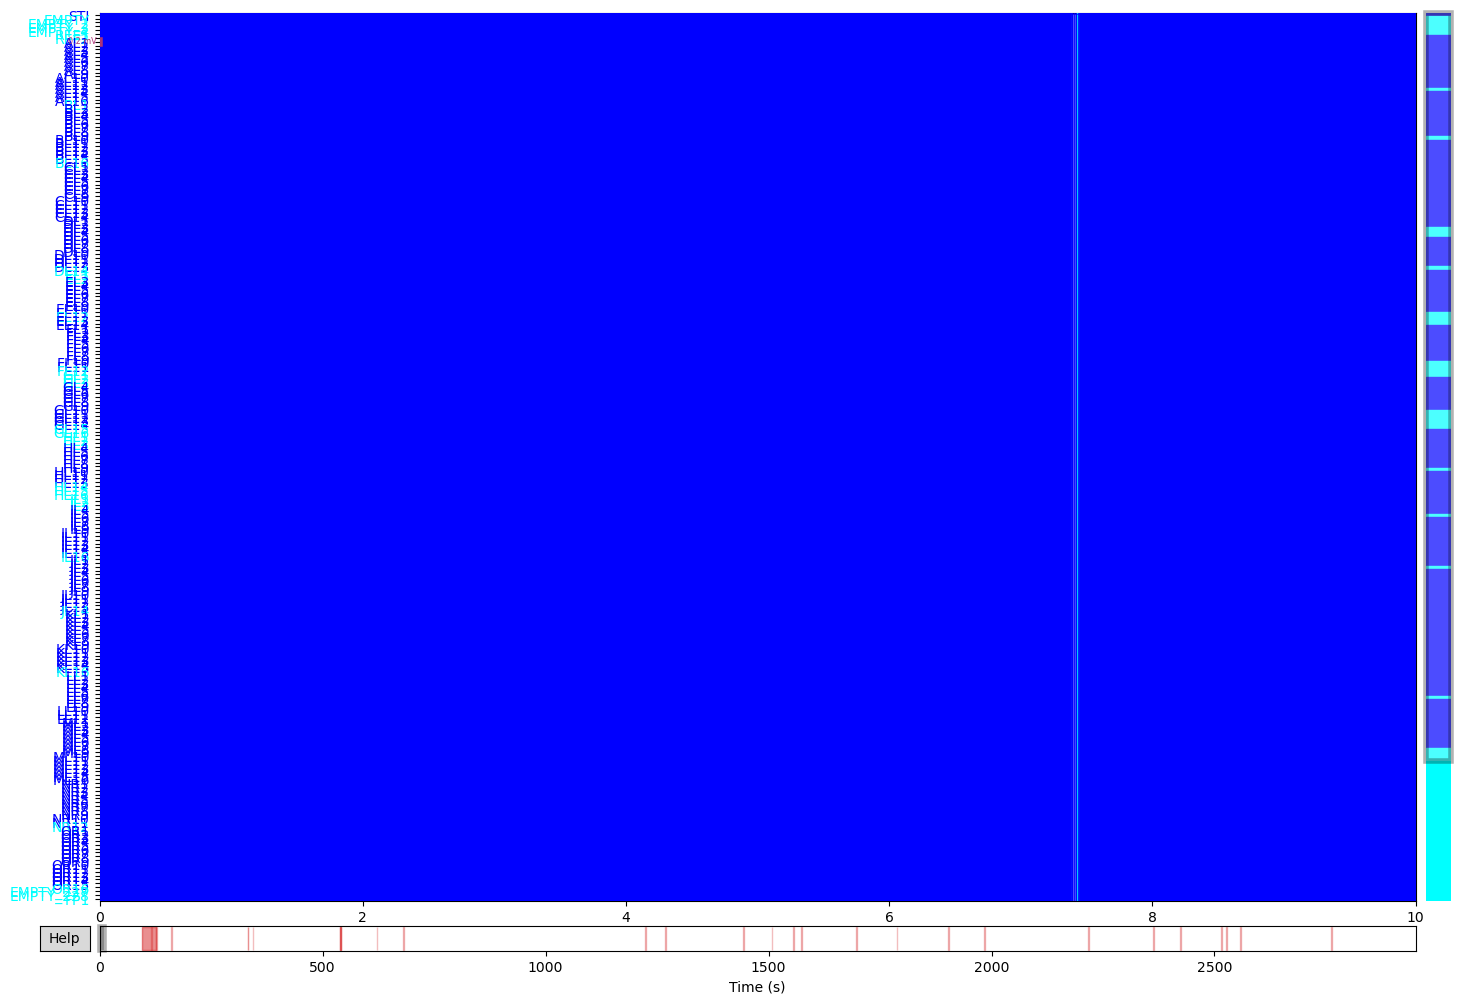

In [10]:

filtered_notch_data.plot(events=events, color='b', bad_color = 'cyan', n_channels = 230, clipping = None, event_color = 'r')

Setting 136700 of 5901900 (2.32%) samples to NaN, retaining 5765200 (97.68%) samples.
Effective window size : 1.024 (s)


/tmp/ipykernel_3501/3957506881.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_notch_data.plot_psd()


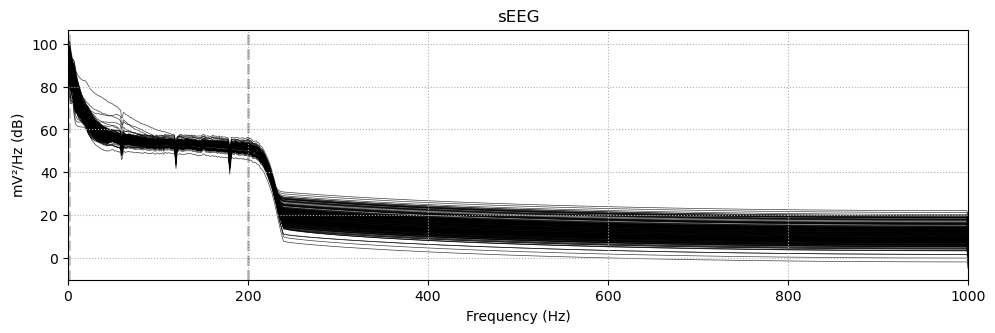

In [17]:
filtered_notch_data.plot_psd()

Setting 136700 of 5901900 (2.32%) samples to NaN, retaining 5765200 (97.68%) samples.
Effective window size : 1.024 (s)


/tmp/ipykernel_3501/973806949.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_notch_data.plot_psd(picks = filtered_notch_data.info['bads'])


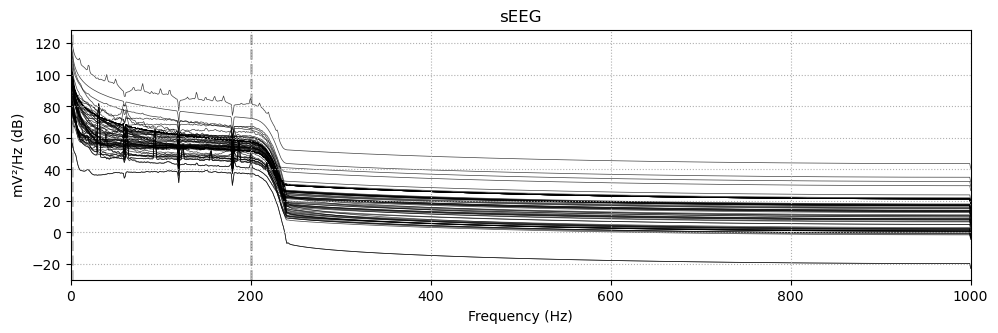

Closing raw-browser...
Channels marked as bad:
['EMPTY', 'EMPTY_2', 'EMPTY_3', 'EMPTY_4', 'REF1', 'REF2', 'EMPTY_227', 'EMPTY_228', 'Ekg1', 'ekg2', 'EMPTY_254', 'EMPTY_255', 'EMPTY_256', 'GL1', 'GL2', 'GL3', 'HL1', 'HL2', 'IL1', 'IL2', 'IL3', 'BL1', 'F8', 'EL1', 'EL2', 'HL14', 'HL15', 'HL16', 'BL16', 'DL14', 'EL12', 'FL12', 'GL16', 'GL15', 'HL16', 'IL16', 'JL14', 'KL16', 'NR12', 'OR16', 'FP1', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T7', 'P7', 'F8', 'T8', 'P8', 'F9', 'F10', 'FPZ', 'FZ', 'CZ', 'PZ', 'OZ', 'DC01', 'DC02', 'DC03', 'DC04', 'DC05', 'DC06', 'DC07', 'DC08', 'DC09', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'HL3', 'HL4']


In [18]:
filtered_notch_data.plot_psd(picks = filtered_notch_data.info['bads'])

In [12]:
def probe_and_num(elec_str): 
    ''' This convenience function takes an electrode string like LHH1 and outputs ('LHH', 1)
    '''
    regex_str = '(\D+)(\d+)' # group of letters followed by group of digits
    matcher = re.compile(regex_str,re.IGNORECASE|re.DOTALL).search(elec_str)
    if matcher:
        probe, num = matcher.groups()
        return probe, int(num)
    else:
        return None, None
    
def find_bipolar_pair(ch, labels, remove):
    ''' Find the pair of a given electrode for bipolar referencing.
        Given a single *ch* and a list of *labels*, some of which you want to *remove*,
        this finds the next channel on that probe that isn't meant to be removed (WM is ok).
    '''
    bipolar_pair = None
    probe, num = probe_and_num(ch)
    other_in_probe = [other_ch for other_ch in labels if probe_and_num(other_ch)[0]==probe]
    for i in range(len(other_in_probe)-num):
        next_ch = probe + str(num+i+1)
        if next_ch in remove or next_ch == 'STI':
            continue
        else:
            bipolar_pair = next_ch
            break
    return bipolar_pair

In [13]:
# Here I iterate through the electrodes in my ROIs and match them up with their bipolar pair
pairs = []
anode = []
cathode = []
pairs_name = []
pairs_map = {}
remove = filtered_notch_data.info['bads']
labels = filtered_notch_data.info['ch_names']
for ch in labels:
    # if a channel is meant to be removed, it doesn't get to be in a bipolar pair
    if ch in remove or ch == 'STI':
        print(f"{ch} noref")
    else:
        pair = find_bipolar_pair(ch, labels, remove)
        if pair:
            anode.append(ch)
            cathode.append(pair)
            pairs.append((ch, pair))
            pairs_map[ch] = f"{ch}-{pair}"
            pairs_name.append(f"{ch}-{pair}")
            # print(ch, pair)

EMPTY noref
EMPTY_2 noref
EMPTY_3 noref
EMPTY_4 noref
REF1 noref
REF2 noref
BL1 noref
BL16 noref
DL14 noref
EL1 noref
EL2 noref
EL12 noref
FL12 noref
GL1 noref
GL2 noref
GL3 noref
GL15 noref
GL16 noref
HL1 noref
HL2 noref
HL3 noref
HL14 noref
HL15 noref
HL16 noref
IL1 noref
IL2 noref
IL3 noref
IL16 noref
JL14 noref
KL16 noref
NR12 noref
OR16 noref
EMPTY_227 noref
EMPTY_228 noref
FP1 noref
F3 noref
C3 noref
P3 noref
O1 noref
FP2 noref
F4 noref
C4 noref
P4 noref
O2 noref
F7 noref
T7 noref
P7 noref
F8 noref
T8 noref
P8 noref
F9 noref
F10 noref
FPZ noref
FZ noref
CZ noref
PZ noref
OZ noref
Ekg1 noref
ekg2 noref
EMPTY_254 noref
EMPTY_255 noref
EMPTY_256 noref
DC01 noref
DC02 noref
DC03 noref
DC04 noref
DC05 noref
DC06 noref
DC07 noref
DC08 noref
DC09 noref
DC10 noref
DC11 noref
DC12 noref
DC13 noref
DC14 noref
DC15 noref
DC16 noref
STI noref


In [14]:
# filtered_notch_data.load_data()

# filtered_notch_bp_data = mne.set_bipolar_reference(filtered_notch_data, anode = anode, cathode = cathode)

# filtered_notch_bp_data.save('./BJH016_notched_filtered_bp_ieeg.fif', overwrite = True)

filtered_notch_bp_data = mne.io.Raw('./BJH016_notched_filtered_bp_ieeg.fif')


Reading 0 ... 5901899  =      0.000 ...  2950.950 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=179, n_times=5901900
    Range : 0 ... 5901899 =      0.000 ...  2950.950 secs
Ready.
Added the following bipolar channels:
AL1-AL2, AL2-AL3, AL3-AL4, AL4-AL5, AL5-AL6, AL6-AL7, AL7-AL8, AL8-AL9, AL9-AL10, AL10-AL11, AL11-AL12, AL12-AL13, AL13-AL14, AL14-AL15, AL15-AL16, BL2-BL3, BL3-BL4, BL4-BL5, BL5-BL6, BL6-BL7, BL7-BL8, BL8-BL9, BL9-BL10, BL10-BL11, BL11-BL12, BL12-BL13, BL13-BL14, BL14-BL15, CL1-CL2, CL2-CL3, CL3-CL4, CL4-CL5, CL5-CL6, CL6-CL7, CL7-CL8, CL8-CL9, CL9-CL10, CL10-CL11, CL11-CL12, CL12-CL13, CL13-CL14, DL1-DL2, DL2-DL3, DL3-DL4, DL4-DL5, DL5-DL6, DL6-DL7, DL7-DL8, DL8-DL9, DL9-DL10, DL10-DL11, DL11-DL12, DL12-DL13, EL3-EL4, EL4-EL5, EL5-EL6, EL6-EL7, EL7-EL8, EL8-EL9, EL9-EL10, EL10-EL11, EL11-EL13, EL13-EL14, FL1-FL2, FL2-FL3, FL3-FL4, FL4-FL5, FL5-FL6, FL6-FL7, FL7-FL8, FL8-FL9, FL9-FL10, FL10-FL11, GL4-GL5, GL5-GL6,

Opening raw-browser...


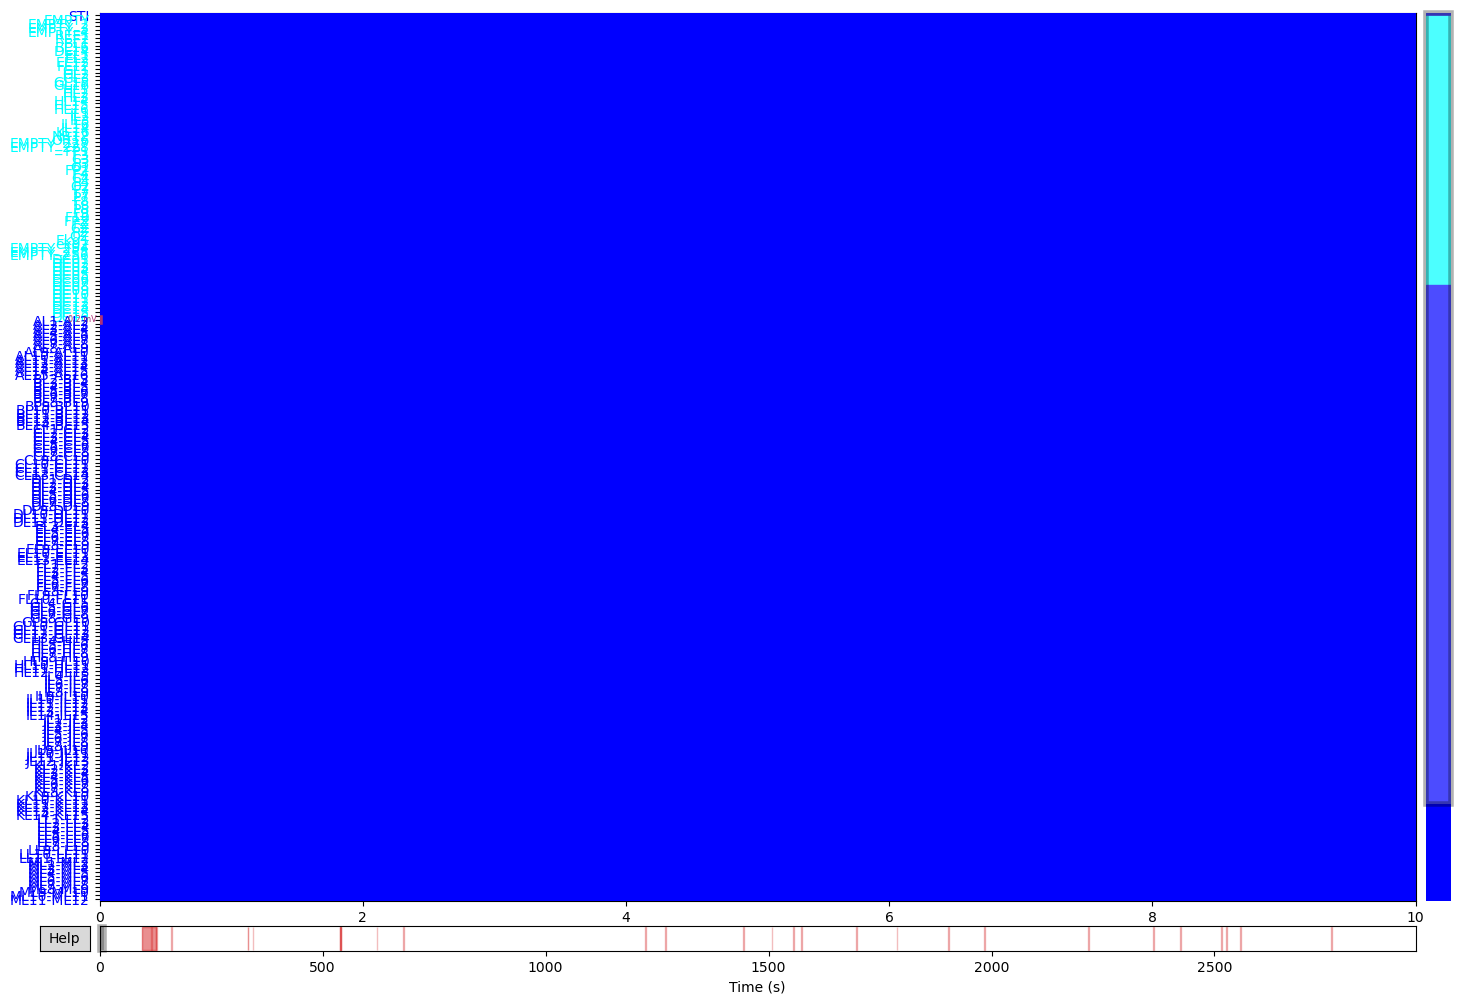

In [15]:
filtered_notch_bp_data.plot(events=events, color='b', bad_color = 'cyan', n_channels = 230, clipping = None, event_color = 'r')

In [47]:
## Dictionary of electrode locations


ROIs = {
    'hc'     :['OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'IL2', 'IL3', 'IL4', 'HL1', 'HL2', 'HL3', 'HL4', 'HL5', 'HL6'],
    'ofc'    :['AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8', 'AL9', 'AL10', 'AL11', 'AL12'],
    'amyg'   :['GL2', 'GL3', 'GL4', 'GL5', 'GL6'],
    'insula' :['BL1', 'BL2', 'BL3', 'BL4', 'BL5',  'BL6', 'BL7', 'BL8', 'BL9', 'LL1', 'LL2', 'LL3', 'LL4'],
    'cing'   :['CL1', 'CL2', 'CL3', 'CL4']
}


In [48]:
hc_list = []
ofc_list = []
amyg_list = []
insula_list = []
cing_list = []

for ix in range(len(pairs_name)):
    if anode[ix] in ROIs['hc'] or cathode[ix] in ROIs['hc']:
        hc_list.append(pairs_name[ix])
    if anode[ix] in ROIs['ofc'] or cathode[ix] in ROIs['ofc']:
        ofc_list.append(pairs_name[ix])
    if anode[ix] in ROIs['amyg'] or cathode[ix] in ROIs['amyg']:
        amyg_list.append(pairs_name[ix])
    if anode[ix] in ROIs['insula'] or cathode[ix] in ROIs['insula']:
        insula_list.append(pairs_name[ix])
    if anode[ix] in ROIs['cing'] or cathode[ix] in ROIs['cing']:
        cing_list.append(pairs_name[ix])        
        


['BL2-BL3',
 'BL3-BL4',
 'BL4-BL5',
 'BL5-BL6',
 'BL6-BL7',
 'BL7-BL8',
 'BL8-BL9',
 'BL9-BL10',
 'LL1-LL2',
 'LL2-LL3',
 'LL3-LL4',
 'LL4-LL5']

Alright, the longest remaining trial is 14 seconds... so we will epoch with .5seconds before and 14s afterwards

In [34]:
channels_of_interest =  [x for x in filtered_notch_bp_data.info['ch_names'] if x not in filtered_notch_bp_data.info['bads']]

epoched_data = mne.Epochs(filtered_notch_bp_data, events, 
                          event_id = 1, tmin = -.5, tmax = 14, 
                          baseline = (-.5, 0), picks = channels_of_interest,
                             reject_by_annotation = False)

good_epochs = [i for i,x in enumerate(epoched_data.get_annotations_per_epoch()) if not x]

Not setting metadata
452 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [35]:
epoch_df = epoched_data.get_data()


Using data from preloaded Raw for 452 events and 29001 original time points ...
0 bad epochs dropped


In [36]:
epoch_df = epoch_df[good_epochs, :, :]

In [37]:
usable_trial_lengths = trial_lengths[0][good_epochs]

In [38]:
def wavelet_transform(sig, fs, freqs, pad_amount=1.5):
    ''' This computes a wavelet transform of some signal, calling neurodsp's `compute_wavelet_transform`
        Here `sig` is the signal you want to transform, `fs` is its sampling rate, and `freqs` are the
        center frequencies. You can optionally include padding around the start and end of the signal
        that then gets cut after the transform. 
    
    '''
    if pad_amount:
        sig_pad = np.pad(sig, int(fs*pad_amount), 'edge')
    mwt = compute_wavelet_transform(sig_pad, fs=fs, freqs=freqs, n_cycles=5)
    return mwt[:, int(fs*pad_amount):len(sig)+int(fs*pad_amount)]

### Hippocampus

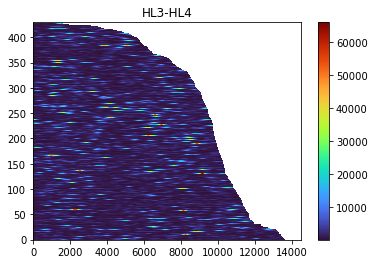

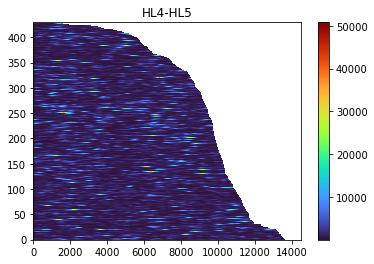

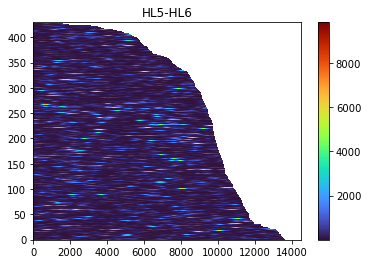

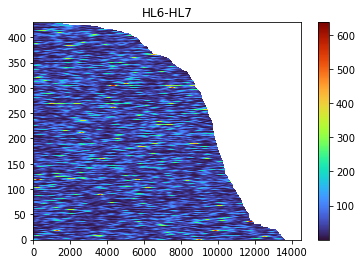

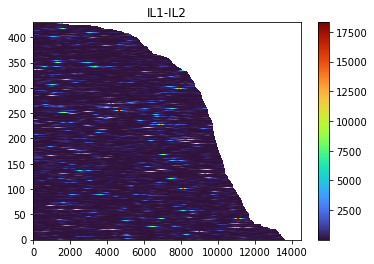

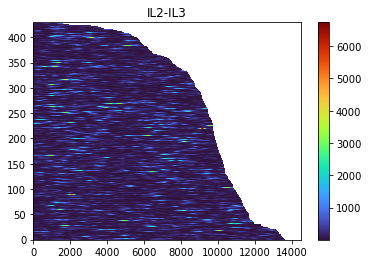

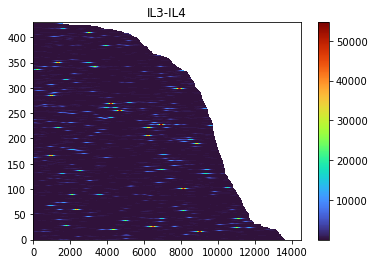

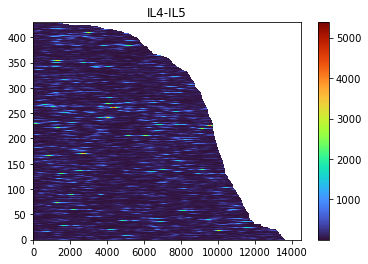

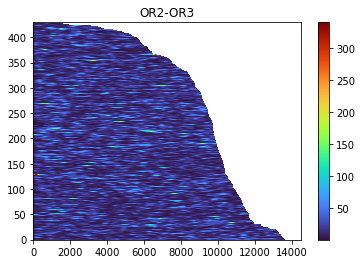

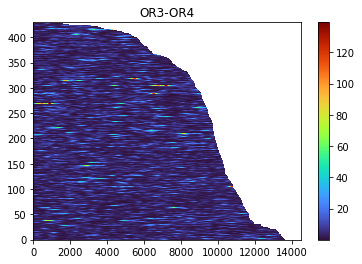

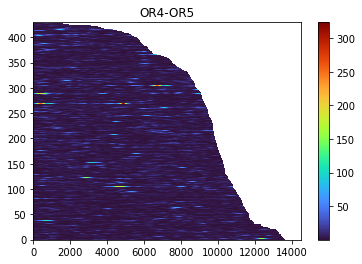

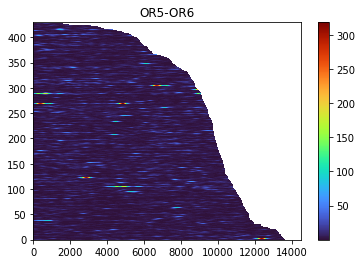

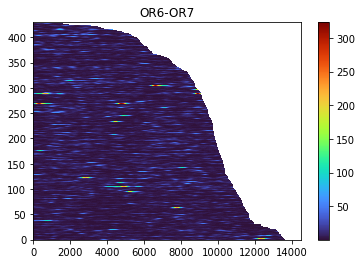

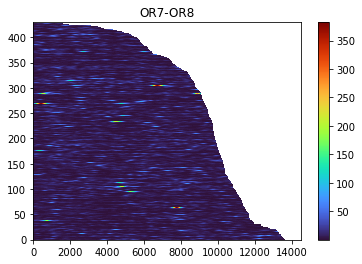

In [52]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in hc_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    
    

### Amygdala

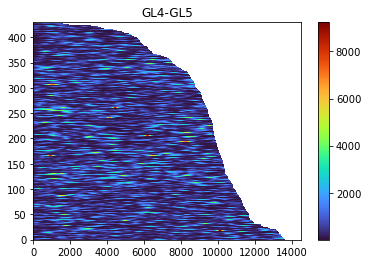

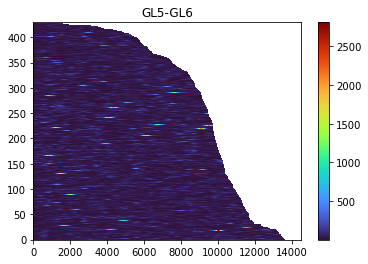

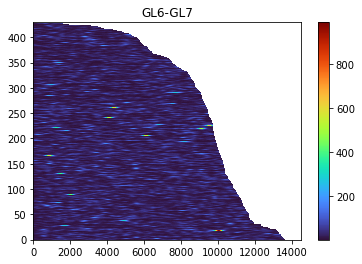

In [53]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in amyg_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    
    

### OFC

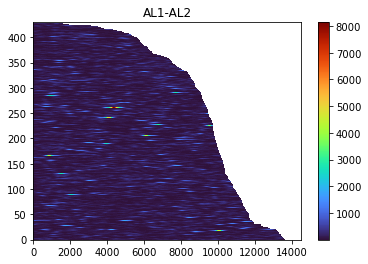

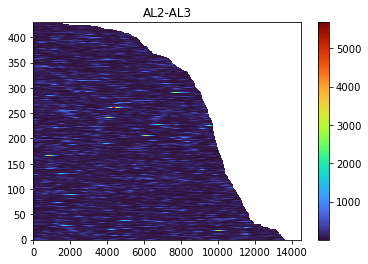

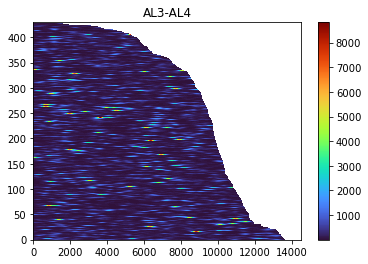

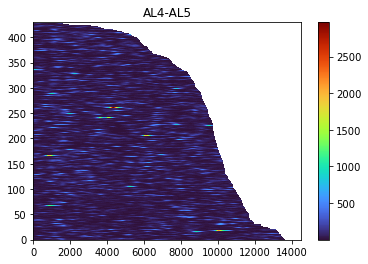

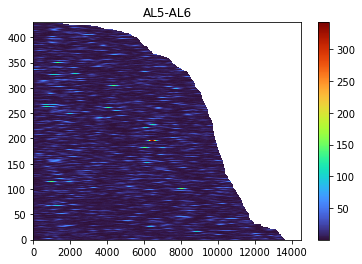

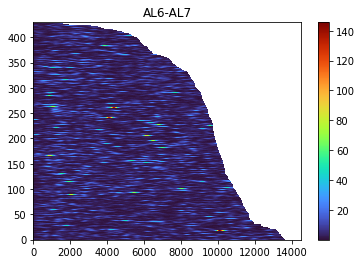

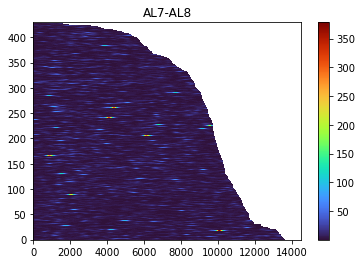

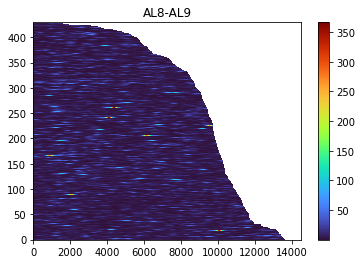

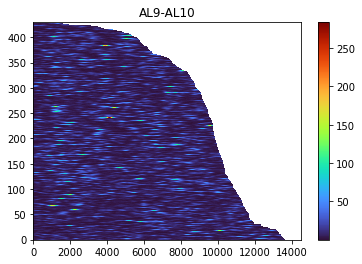

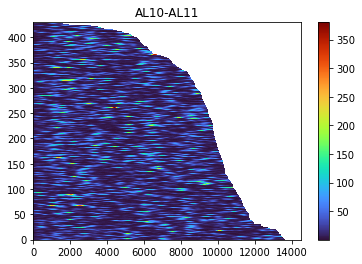

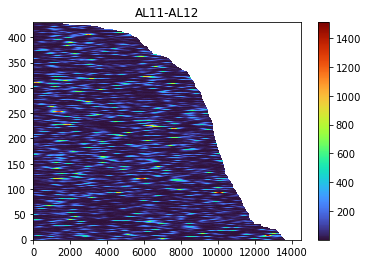

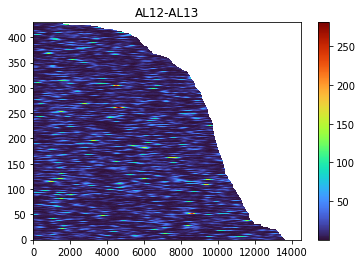

In [54]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in ofc_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    

### Insula

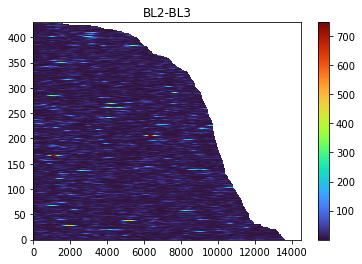

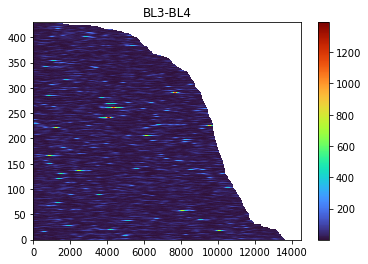

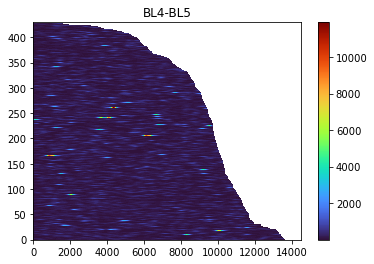

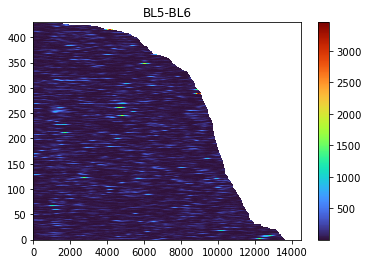

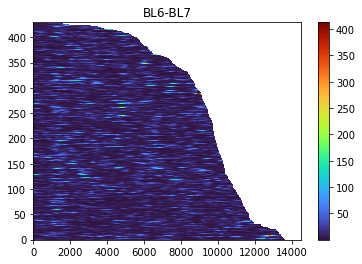

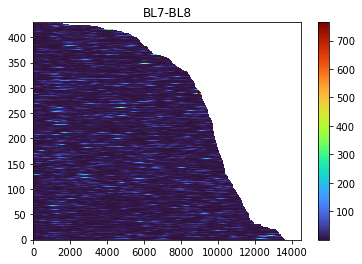

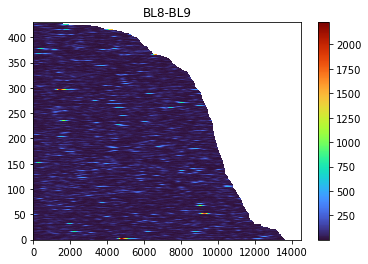

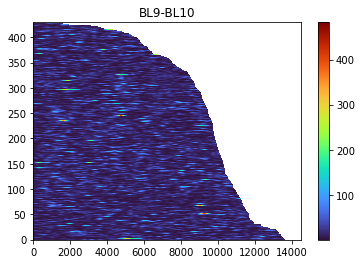

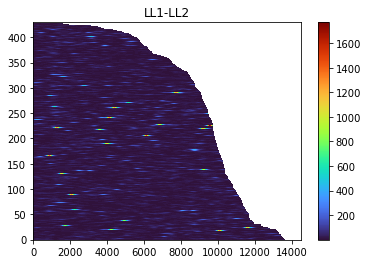

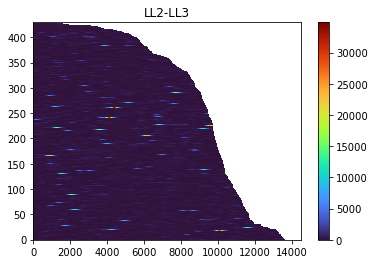

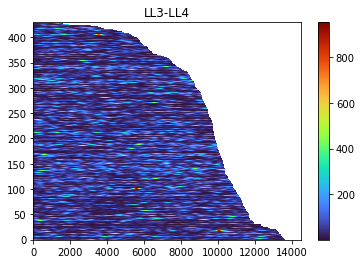

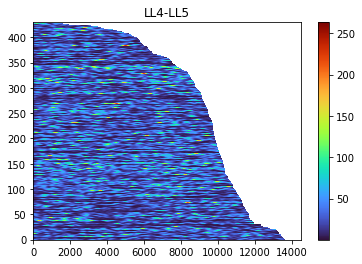

In [55]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in insula_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    

### Anterior Cingulate

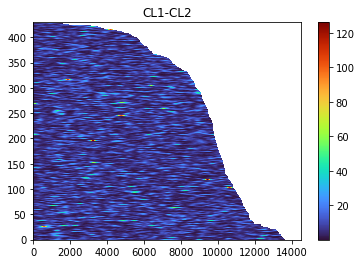

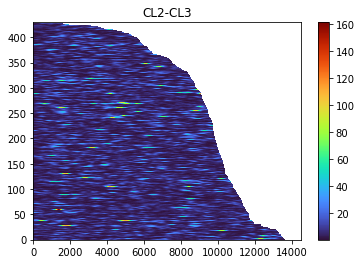

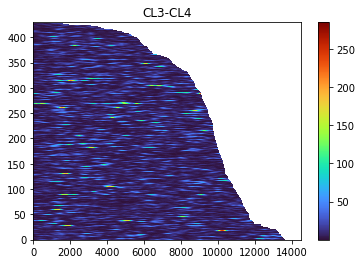

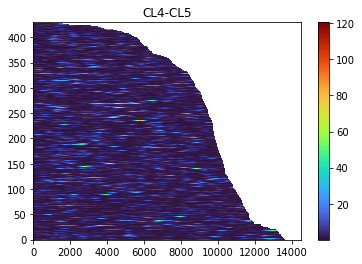

In [56]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in cing_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    